In [12]:
%matplotlib notebook 
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from scipy import interpolate
from scipy.optimize import root


# Cagniard de Hoop Method

This should be a clean notebook containing a Cagniard de Hoop path finder and wrapper functions. Scratch work is in Cagniard_Path_JP.ipynb.

## Use (and evidence of shortcomings)
1. This code is set up for two layers and a receiver at the surface. The interface depth is z, the source depth is h. So, for the transmission case, h>z is necessary. These vertical distances are taken in a zs array, [z,h]. This needs to be extended to more layers.
2. Pick an x distance.
3. Code the velocities into the B array starting with the top layer.
4. Choose a ray path and make or find the appropriate tfunc.
5. Edit the end of the run_plot function to use the appropriate reflection/transmission coefficients.
6. run_plot(x,zs,B,tfunc,tmax) where tmax is in seconds
7. I have no idea what the amplitude of the seismogram means currently - need to figure out units.

comp time:  2.64717793465 s


<IPython.core.display.Javascript object>


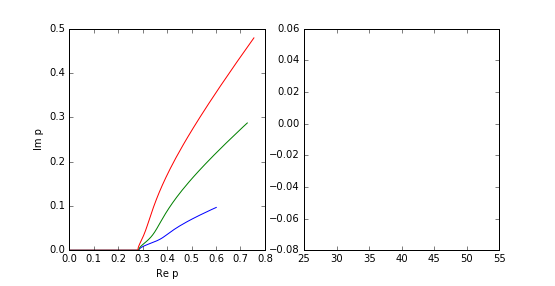

In [11]:
z = 5
x = 40
h = 8
B = [2.5, 3.5]
rho = [2.0, 2.7]
# R = R_reflect(x,[z,h]) defunct!
run_plot_more(x,[z,h],B,rho,25)

## Pieces
* The material has layer depths and velocities
* The ray is defined by x and z values
* ~~The ray defines an R value~~
* The max time depends on how far the receiver is, arbitrary for now

In [2]:
#Path finding function
#No edits necessary to run right now
def t_from_p(x, zs, B, tfunc, tmax):
    z = zs[0]
    h = zs[1]
    p = [0*1j]
    t = [tfunc(p[0],B).real]
    
    while t[-1] < tmax:
        w0 = p[-1].real
        y0 = p[-1].imag
        coords = []
        for theta in range(0,90):
            th = theta*math.pi/180
            w = w0 + np.cos(th)*.0005
            y = y0 + np.sin(th)*.0005
            coords.append((w,y))
        tvals = [tfunc(complex(*coord),B) for coord in coords]
        t_ind = np.argmax([tv.real for tv in tvals])
        t.append(tvals[t_ind].real)
        p.append(complex(*coords[t_ind]))
    
    return t, np.array(p)

In [3]:
#Define tfuncs for ray paths
#Choose one for each run of code
def t_direct(p1):
    return p1*x + np.sqrt(B[0]**(-2)-p1**2)*z                     
def t_reflect(p1,B):
    #calc t vector from p
    return p1*x+(z-h)*np.sqrt(1/B[0]**2-p1**2) + (z)*np.sqrt(1/B[0]**2-p1**2);
def t_transmit(p1,B):
    return p1*x + (h-z)*np.sqrt(1/B[1]**2-p1**2) + z*np.sqrt(1/B[0]**2-p1**2);
def t_trans_m1(p1,B):
    return p1*x + (h-z)*np.sqrt(1/B[1]**2-p1**2) + 3*z*np.sqrt(1/B[0]**2-p1**2);
def t_trans_m2(p1,B):
    return p1*x + (h-z)*np.sqrt(1/B[1]**2-p1**2) + 5*z*np.sqrt(1/B[0]**2-p1**2);

In [21]:
#Running the finder and plotting results
#TODO The reflection and transmission coefficients must be selected inside this function currently
def run_plot(x,zs,B,tfunc,tmax):
    z = zs[0]
    h = zs[1]
    ts = time.time()
    t2, p2 = t_from_p(x,zs,B,tfunc,tmax)
    tf = time.time()-ts
    print "comp time: ", tf, "s"
    fig, ax = plt.subplots(1, 2, figsize = (6,3))
    ax[0].plot(p2.real,p2.imag)
    ax[0].set_xlabel("Re p")
    ax[0].set_ylabel("Im p")
    ax[0].set_xlim([.25, .45])

    #interpolate p(t) to regular t increment 
    dt = .01
    f=interpolate.interp1d(t2,p2);
    xi=np.arange(t2[0],t2[-1],dt);
    yi = f(xi)
    dpdt=np.diff(yi)/0.01;
    u=np.imag(dpdt*yi[:-1]**1.5/np.sqrt(1/2.5**2-yi[:-1]**2));
    ax[1].plot(xi[:-1],u)

    # Refection coefficient
    rho0=2.0;
    rho=2.7;
    mu0=(B[0]*1.e05)**2*rho0;
    mu=(B[1]*1.e05)**2*rho;
    Re=(mu0*np.sqrt(1/B[0]**2-yi[:-1]**2)-mu*np.sqrt(1/B[1]**2-yi[:-1]**2)
      )/(mu0*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu*np.sqrt(1/B[1]**2-yi[:-1]**2));
    
    # Transmission coefficient
    Tr = 2*mu*np.sqrt(1/B[1]**2-yi[:-1]**2)/(mu0*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu*np.sqrt(1/B[1]**2-yi[:-1]**2))
    
    # Displacement output
    u2=np.imag(Tr*dpdt*yi[:-1]**1.5/np.sqrt(1/B[0]**2-yi[:-1]**2));

    ax[1].plot(xi[:-1],-1*u2)
    ax[1].set_xlim([25, 55])

    plt.show()

In [6]:
#Running the finder and plotting results
#TODO The reflection and transmission coefficients must be selected inside this function currently
def run_plot_more(x,zs,B,rh,tmax):
    z = zs[0]
    h = zs[1]
    ts = time.time()
    td, pd = t_from_p(x,zs,B,t_transmit,tmax)
    tm1, pm1 = t_from_p(x,zs,B,t_trans_m1,tmax+10)
    tm2, pm2 = t_from_p(x,zs,B,t_trans_m2,tmax+20)
    tf = time.time()-ts
    print "comp time: ", tf, "s"
    fig, ax = plt.subplots(1, 2, figsize = (6,3))
    ax[0].plot(pd.real,pd.imag)
    ax[0].plot(pm1.real,pm1.imag)
    ax[0].plot(pm2.real,pm2.imag)
    ax[0].set_xlabel("Re p")
    ax[0].set_ylabel("Im p")
#     ax[0].set_xlim([.25, .45])

    #interpolate p(t) to regular t increment 
    dt = .01
    f=interpolate.interp1d(td,pd);
    xi_d=np.arange(td[0],td[-1],dt);
    yi_d = f(xi_d)
    dpdt_d=np.diff(yi_d)/0.01;
    u_d=np.imag(dpdt_d*yi_d[:-1]**1.5/np.sqrt(1/2.5**2-yi_d[:-1]**2));
    ax[1].plot(xi_d[:-1],u_d)

    # Reflection coefficient
    mu0=(B[0]*1.e05)**2*rh[0];
    mu=(B[1]*1.e05)**2*rh[1];
#     Re=(mu0*np.sqrt(1/B[0]**2-yi[:-1]**2)-mu*np.sqrt(1/B[1]**2-yi[:-1]**2)
#       )/(mu0*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu*np.sqrt(1/B[1]**2-yi[:-1]**2));

    # Direct transmission ray
    # Transmission coefficient
    Tr = 2*mu*np.sqrt(1/B[1]**2-yi_d[:-1]**2)/(mu0*np.sqrt(1/B[0]**2-yi_d[:-1]**2)+mu*np.sqrt(1/B[1]**2-yi_d[:-1]**2))
    
    # Displacement output
    u2_d=np.imag(Tr*dpdt_d*yi_d[:-1]**1.5/np.sqrt(1/B[0]**2-yi_d[:-1]**2));

    ax[1].plot(xi_d[:-1],-1*u2_d)
    ax[1].set_xlim([25, 55])

    plt.show()

# plot the whole quadrant and compare p contours 

comp time:  0.581228971481 s
Elapsed time is 3.20837903023 seconds.


(0.3, 0.45000000000000001)

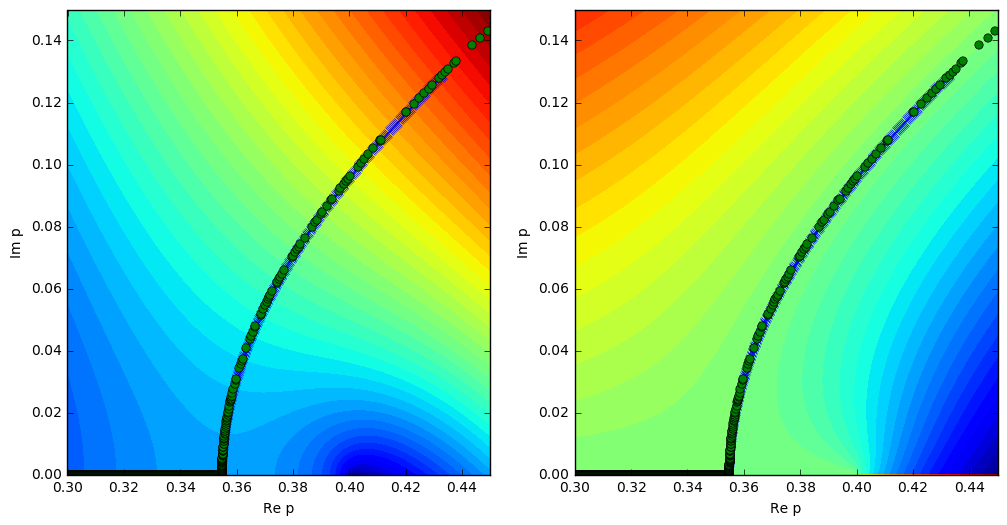

In [12]:
z = 30
x = 100
h = 8
B = [2.5, 3.5]
R = R_reflect(x,[z,h])
ts = time.time()
t2, p2 = t_from_p(x,[z,h],B,t_reflect,55)
tf = time.time()-ts
print "comp time: ", tf, "s"
fig, ax = plt.subplots(1, 2, figsize = (12,6))
ax[0].plot(p2.real,p2.imag,'x')
ax[0].set_xlabel("Re p")
ax[0].set_ylabel("Im p")
ts = time.time()
# t3, p3 = t_from_p2(x,[z,h],B,t_reflect,55)
# tf = time.time()-ts
# print "comp time: ", tf, "s"
ax[1].plot(p2.real,p2.imag,'x')
ax[1].set_xlabel("Re p")
ax[1].set_ylabel("Im p")

dp = .0001
rp = np.linspace(0.3,0.45,.15/dp)
ip = np.linspace(0,.15,.15/dp)
RP,IP = np.meshgrid(rp,ip)
p = RP+1j*IP
t = p*x+(z-h)*np.sqrt(1/B[0]**2-p**2) + (z)*np.sqrt(1/B[0]**2-p**2);
tr = np.log10(t.real)
ax[0].contourf(rp,ip,t.real,50)
ax[1].contourf(rp,ip,t.imag,50)

# Add Doug's
r=100.;
z=30.;
h=8;
beta0=2.5;
rho0=2.0;
beta=3.5;
rho=2.7;
mu0=(beta0*1.e05)**2*rho0;
mu=(beta*1.e05)**2*rho;

dt=0.01;
dpr=0.0001;
dpi=0.0001;
pmin=0.25;
pmax=0.45;
tres=0.0002;

tic() #start the clock

# generate an empty grid search domain for complex p
tmp1=np.arange(pmin,pmax+dpr,dpr)
tmp2=np.arange(0,pmax-pmin+dpi,dpi)
nn1=len(tmp1)
nn2=len(tmp2)
preal=np.tile(tmp1, [nn2,1]);
pimag=np.tile(tmp2, [nn1,1]);
p=preal + 1j*(pimag).T;

#calc t vector from p
t=p*r+(z-h)*np.sqrt(1/beta0**2-p**2) + (z)*np.sqrt(1/beta0**2-p**2);


# grid search for indicies of t that real
[k, l]=np.where(abs(np.imag(t)) < tres); 
#
tt=[]
pp=[]
cnt=0
for J in range(0,len(k)):
    if J==0:
        tt.append(np.real(t[k[J],l[J]]))
        pp.append(p[k[J],l[J]])
        cnt+=1
    elif np.real(t[k[J],l[J]]) > tt[cnt-1]:
        tt.append(np.real(t[k[J],l[J]]));
        pp.append(p[k[J],l[J]]);
        cnt+=1

toc() #stop the clock

#plot contour integration in p domain
ax[0].plot(np.real(pp),np.imag(pp),'o')
ax[0].set_xlim(left=.3)
# ax[0].set_ylim([0,.06])
ax[1].plot(np.real(pp),np.imag(pp),'o')
ax[1].set_xlim(left=.3)
# ax[1].set_ylim([0,.06])

## Source-time function

In [ ]:
#u2_d from above is the sum of the imaginary integrands

# Now defunct
* R functions
* MATLAB conversion codes for full grid search (Doug's)

In [7]:
#Define R functions
def R_direct(x,zs):
    return np.sqrt(x**2 + zs[1]**2)
def R_reflect(x,zs):
    return np.sqrt(x**2 + (2*z-h)**2)
def R_transmit(x,zs,B):
    xa = root(lambda a:((x-a)**2*(a**2+(h-z)**2))*B[1]**2 - ((x-a)**2+z**2)*(a*B[0])**2,20)
    print xa
    return np.sqrt((xa**2+(h-z)**2)) + np.sqrt((x-xa)**2+z**2)

In [8]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

def cartesian(arrays, out=None):
    """
    CREDIT: http://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays
    
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out
